# Image Processing with Python: Color Correction using White Balancing Methods

by: Jephraim C. Manansala | Published on https://jephraim-manansala.medium.com/

### How can we correct colors in digital images?

In this post, we will explore how the colors in the images can be corrected using white balancing techniques.

Let’s begin.

As usual, we import libraries such as `numpy` and `matplotlib`. Additionally, we import specific functions from the `skimage` library. We also import the Rectangle function from `matplotlib.patches`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.io import imread, imshow
from skimage import img_as_ubyte

Let us use an image of the dining table arrangement in a formal event I attended in a hotel in Metro Manila. 

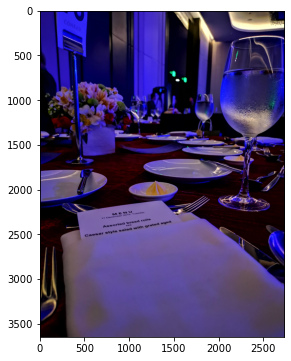

In [2]:
dinner = imread('dinner.jpg')
plt.figure(figsize=(6,6))
plt.imshow(dinner, cmap='gray')

Notice how there is a blue-ish tint in the image due to the strobe lights in the event. Let’s try to remove this tint to show the actual colors of the object in the image.

Let’s start by using the **white patch algorithm**. The objective of this algorithm is to normalize each image channel to the specific value from that channel. Let’s start by using the maximum intensity value from each channel.

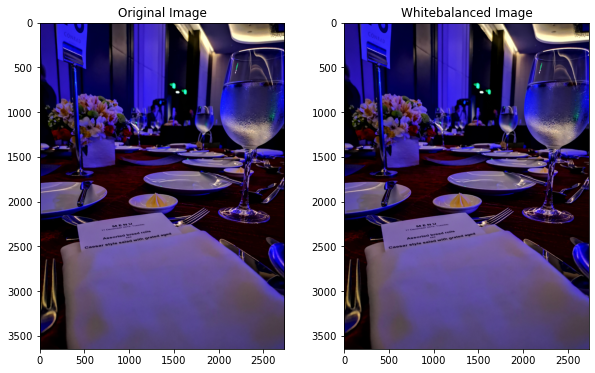

In [3]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].imshow(dinner)
ax[0].set_title('Original Image')
dinner_max = (dinner*1.0 / dinner.max(axis=(0,1)))
ax[1].imshow(dinner_max);
ax[1].set_title('Whitebalanced Image');

See any difference? There isn’t any! By getting the value of the maximum intensity value from each channel using the `dinner.max(axis=(0,1)`, we can see that all channels have a maximum intensity value of 255, which can be attributed to the white lights in the ceiling. This signifies that we cannot perform white balancing using the maximum intensity value from each channel to an image with bright specks of light.

Let’s try a different assumption. We can use the *mean intensity values* from each channel to normalize the intensity values in the image.

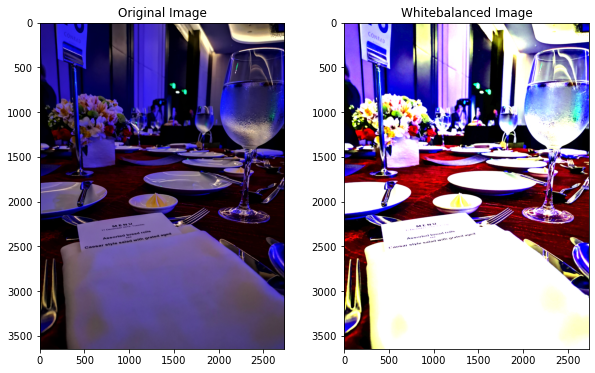

In [4]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].imshow(dinner)
ax[0].set_title('Original Image')
dinner_mean = (dinner*1.0 / dinner.mean(axis=(0,1)))
ax[1].imshow(dinner_mean.clip(0, 1))
ax[1].set_title('Whitebalanced Image');

It is evident how correcting the image using the mean intensity value in each channel can correct its colors. However, it seems that the colors became too bright. By setting the white patch as the mean intensity value, all values having this value and all values greater than this value are clipped to have the maximum intensity value. This results in a really bright image.

We can improve this by normalizing the image using *specific percentile values* in each channel. Here is a function I created that outputs the histogram of image intensities and each channel’s percentile values.

In [5]:
def percentile_whitebalance(image, percentile_value):

    fig, ax = plt.subplots(1,2, figsize=(12,6))

    for channel, color in enumerate('rgb'):
        channel_values = image[:,:,channel]
        value = np.percentile(channel_values, percentile_value)
        ax[0].step(np.arange(256), 
                   np.bincount(channel_values.flatten(), 
                               minlength=256)*1.0 / channel_values.size, 
                   c=color)
        ax[0].set_xlim(0, 255)
        ax[0].axvline(value, ls='--', c=color)
        ax[0].text(value-70, .01+.012*channel, 
                   "{}_max_value = {}".format(color, value), 
                    weight='bold', fontsize=10)
    ax[0].set_xlabel('channel value')
    ax[0].set_ylabel('fraction of pixels');
    ax[0].set_title('Histogram of colors in RGB channels')    
    whitebalanced = img_as_ubyte(
            (image*1.0 / np.percentile(image, percentile_value, axis=(0, 1)))
            .clip(0, 1))
    ax[1].imshow(whitebalanced);
    ax[1].set_title('Whitebalanced Image')
    return ax

By assuming that the white patch is set at 99% percentile of the image intensity values, we have:

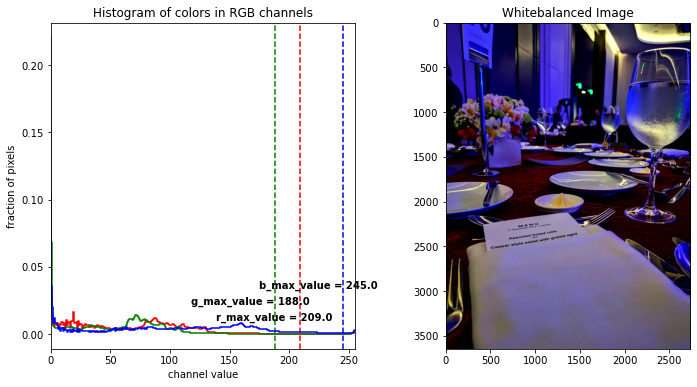

In [6]:
percentile_whitebalance(dinner, 99);

By setting the 99% percentile intensity values as the white patch to normalize the image, we can see that the resulting image had a less blue-ish tint. Let’s try to lower this percentile value to 97.5%.

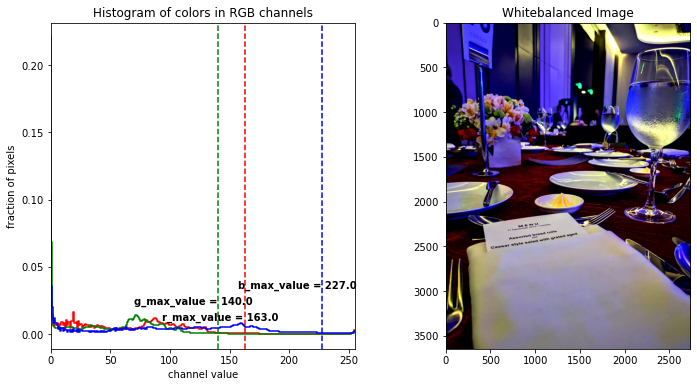

In [7]:
percentile_whitebalance(dinner, 97.5);

When the white patch is set at 97.5% percentile, the corrected image has a much lesser blue-ish tint. This image is pretty decent since the color shades of the objects nearest to the camera have been restored to their original colors.

Let’s see if we can improve this by using the **gray-world algorithm**. The gray-world algorithm assumes that the pixels are neutral gray on average because there is a good distribution of colors in the image. Therefore, we can estimate the pixel color by looking at the average color and comparing it to gray.

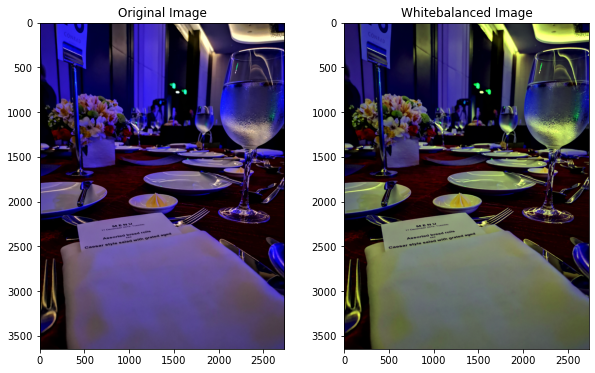

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].imshow(dinner)
ax[0].set_title('Original Image')
dinner_gw = ((dinner * (dinner.mean() / dinner.mean(axis=(0, 1))))
             .clip(0, 255).astype(int))
ax[1].imshow(dinner_gw);
ax[1].set_title('Whitebalanced Image');

The image corrected by the gray world algorithm seems to have a yellowish tint on the supposedly white objects. This is probably the case because the gray world algorithm’s assumption that there is a good distribution of colors in the image does not hold true for this specific image. This is evident in the histograms of intensity values, as shown in the examples of the white patch algorithm.

With this in mind, let us try the **ground truth algorithm**. In this algorithm, we can manually select a “true” white patch and use that to rescale each channel.

Let’s see how this works. Below is a function I created to juxtapose the results of this algorithm.

In [9]:
def whitepatch_balancing(image, from_row, from_column, 
                         row_width, column_width):

    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(dinner)
    ax[0].add_patch(Rectangle((from_column, from_row), 
                              column_width, 
                              row_width, 
                              linewidth=3,
                              edgecolor='r', facecolor='none'));
    ax[0].set_title('Original image')

    dinner_patch = dinner[from_row:from_row+row_width, 
                          from_column:from_column+column_width]

    dinner_max = (dinner*1.0 / 
                  dinner_patch.max(axis=(0, 1))).clip(0, 1)
    ax[1].imshow(dinner_max);
    ax[1].set_title('Whitebalanced Image')
    plt.tight_layout()

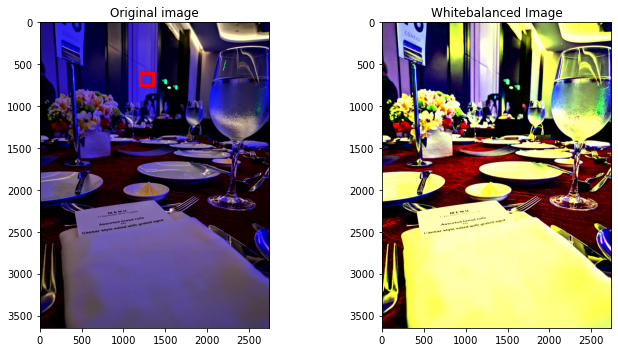

In [10]:
whitepatch_balancing(dinner, 600, 1200, 150, 150)

By setting the white patch ground truth at the column in the background, we can see that the objects farther away from the camera achieved good color correction. However, this is at the expense of the images that are near the camera. Let’s try to improve on this.

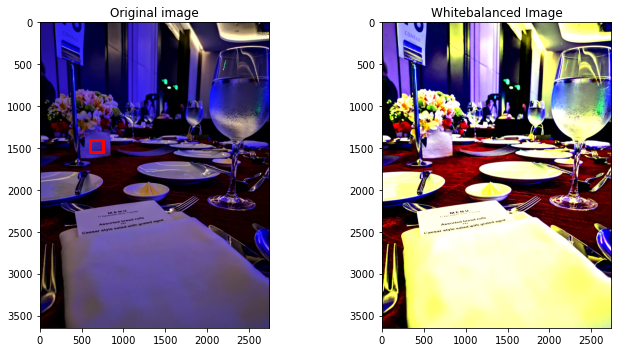

In [11]:
whitepatch_balancing(dinner, 1400, 600, 150, 150)

By setting the white patch ground truth at the flower vase, we can see that this flower vase is now white on the corrected image. However, it seems that this color correction is only good for objects in the middle of the image. Other objects farther away and nearer from the camera are still not correctly corrected. Let’s try other white patch ground truths.

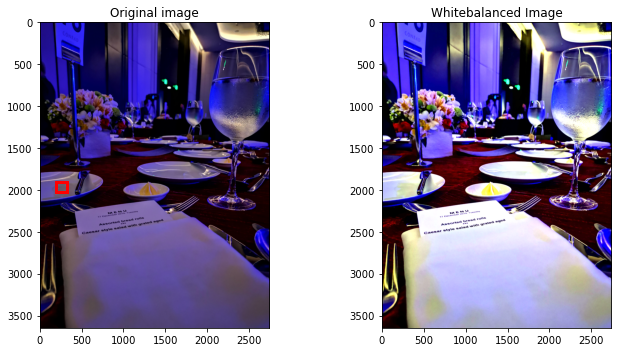

In [12]:
whitepatch_balancing(dinner, 1900, 200, 120, 120)

By setting the white patch ground truth at the plate, we can see that objects nearer the camera have the blue-ish tint removed. However, it seems that other object that is farther away in the image kept their blue-ish tint. This signifies that the objects in the image are exposed to varying levels of blue light.

All of the algorithms presented above assume a single value reference to normalize and correct the image’s colors. Since the objects have varying blue-ish tint levels, it is upon the data scientist’s discretion on which objects to prioritize having their colors corrected.

#### In summary

We have explored how to correct the colors in an image using the white patch algorithm, gray world algorithm, and ground truth algorithm. Upon inspecting the corrected images, we can conclude that there is no *“one-size-fits-all”* solution in fixing the colors of an image. Each algorithm has its own strengths and weaknesses, and it is upon the discretion of the data scientist to determine which technique is best for their applications.
